<a href="https://colab.research.google.com/github/jiyoon-park97/AIFFEL_quest_cr/blob/main/jellyfish_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ResNet으로 학습, 평가

In [49]:
!pip install wandb==0.19.8

In [50]:
!pip install torch torchvision wandb

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import wandb

In [52]:
wandb.login()

True

In [53]:
wandb.init(
    project = "jellyfish-classification",
    name = "resnet50-baseline",
    config = {
        "epochs": 5,
        "batch_size": 32,
        "learning_rate": 0.001,
        "model": "ResNet-50"
    }
)

config = wandb.config

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
data_dir = "/content/drive/MyDrive/AIFFEL_DLTHON/Train_Test_Valid"

In [56]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [57]:
train_dataset = datasets.ImageFolder(root=data_dir + '/Train', transform=transform)
val_dataset = datasets.ImageFolder(root=data_dir+'/valid', transform= transform)


In [58]:
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

print(f"Train데이터: {len(train_dataset)}장 / Validation 데이터: {len(val_dataset)}장")

Train데이터: 900장 / Validation 데이터: 39장


In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
model = models.resnet50 (pretrained = True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.9MB/s]


In [61]:
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

In [63]:
for epoch in range(config.epochs):
    model.train()
    train_loss =0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_loader.dataset)

    model.eval()
    val_loss = 0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)

    wandb.log({
        "Epoch": epoch + 1,
        "Train :Loss": train_loss / len(train_loader),
        "Train Accuracy": train_acc,
        "Validation Loss": val_loss / len(val_loader),
        "Validation Accuracy": val_acc
    })

    print(f"Epoch [{epoch+1}/ {config.epochs}],"
          f"Train Loss: {train_loss/ len(train_loader):.4f},"
          f"Val Loss: {val_loss/len(val_loader): .4f},"
          f"Val Acc: {val_acc:.4f}")


Epoch [1/ 5],Train Loss: 1.3077,Val Loss:  21.1341,Val Acc: 0.2051
Epoch [2/ 5],Train Loss: 0.9345,Val Loss:  1.4089,Val Acc: 0.4872
Epoch [3/ 5],Train Loss: 0.7731,Val Loss:  2.3697,Val Acc: 0.4872
Epoch [4/ 5],Train Loss: 0.6490,Val Loss:  2.0359,Val Acc: 0.5128
Epoch [5/ 5],Train Loss: 0.6366,Val Loss:  2.1595,Val Acc: 0.5128


In [64]:
torch.save(model.state_dict(), "/content/drive/MyDrive/AIFFEL_DLTHON/jellyfish-resnet50.pth")


예측 결과:barrel_jellyfish


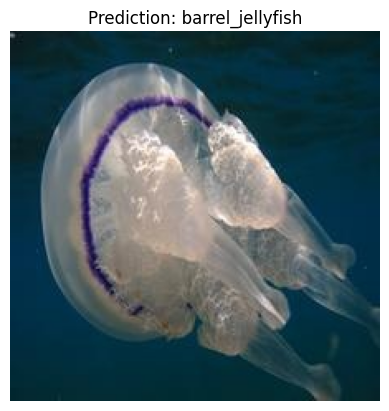

In [65]:
##사진 한 장 실험##

from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/AIFFEL_DLTHON/Train_Test_Valid/test/barrel_jellyfish/08.jpg'

image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

input_image = transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(input_image)
    pred = output.argmax(1).item()

class_name = train_dataset.classes[pred]
print(f"예측 결과:{class_name}")

plt.imshow(image)
plt.title(f"Prediction: {class_name}")
plt.axis('off')
plt.show()

In [66]:
##test data 전체 데이터 실험##

test_dataset = datasets.ImageFolder(root=data_dir+'/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

model.eval()
test_correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = test_correct / len(test_loader.dataset)
print(f"테스트 정확도:{test_acc*100:.2f}%")

테스트 정확도:65.00%


#ResNet결과 히트맵으로 나타내기

In [67]:
!pip install grad-cam

In [68]:
import torch
from torchvision import models,transforms
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet50(pretrained=False)
model.fc= torch.nn.Linear(model.fc.in_features, 6)
model.load_state_dict(torch.load("/content/drive/MyDrive/AIFFEL_DLTHON/jellyfish-resnet50.pth"))
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [71]:
image_path = '/content/drive/MyDrive/AIFFEL_DLTHON/Train_Test_Valid/test/compass_jellyfish/04.jpg'

image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

input_tensor = transform(image).unsqueeze(0).to(device)

rgb_img=transforms.ToTensor()(image).permute(1,2,0).numpy()

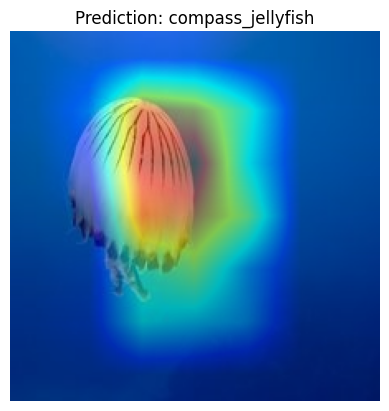

In [74]:
target_layer = model.layer4[-1]

cam= GradCAM(model=model, target_layers= [target_layer])

output = model(input_tensor)
class_name = train_dataset.classes[pred_class]
plt.title(f"Prediction: {class_name}")

targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=input_tensor, targets= targets)[0]

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title(f"Prediction: {train_dataset.classes[pred_class]}")
plt.axis('off')
plt.show()

#Efficient Net으로 학습 및 실험

In [1]:
!pip install torch torchvision wandb efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=f82fe45eac3d81f22991f8a670826916064edfe5aa79920cd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
import wandb


In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjy5081a (pjy5081a-aiffel) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [20]:
wandb.init(
    project = 'jellyfish-classification',
    name='efficientnet-b0',
    config={
        "epochs": 5,
        "batch_size": 32,
        "learning_rate": 0.001,
        "model": "EfficientNet-Bo"
    }
)

config = wandb.config

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
data_dir = "/content/drive/MyDrive/AIFFEL_DLTHON/Train_Test_Valid"

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [13]:
train_dataset = datasets.ImageFolder(root=data_dir+'/Train', transform=transform)
val_dataset = datasets.ImageFolder(root=data_dir + '/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

In [14]:
print(f"클래스 목록: {train_dataset.classes}")
num_classes = len(train_dataset.classes)

클래스 목록: ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )

model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc= nn.Linear(model._fc.in_features, num_classes)
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 99.1MB/s]


Loaded pretrained weights for efficientnet-b0


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= config.learning_rate)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)


In [23]:
for epoch in range(config.epochs):
    model.train()
    train_loss = 0
    train_correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = train_correct / len(train_loader.dataset)

    model.eval()
    val_loss = 0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)

    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss" : train_loss / len(train_loader),
        "Train Accuracy": train_acc,
        "Validation Loss" : val_loss / len(val_loader),
        "Validation Accuracy": val_acc
    })

    print(f"Epoch[{epoch+1}/{config.epochs}], "
          f"Train Loss: {train_loss/ len(train_loader):.4f},"
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Acc: {val_acc:.4f}")

wandb.finish()

Epoch[1/5], Train Loss: 0.1740,Val Loss: 2.4130, Val Acc: 0.6923
Epoch[2/5], Train Loss: 0.1253,Val Loss: 1.9672, Val Acc: 0.6923
Epoch[3/5], Train Loss: 0.0755,Val Loss: 2.2533, Val Acc: 0.6667
Epoch[4/5], Train Loss: 0.0338,Val Loss: 2.7993, Val Acc: 0.6667
Epoch[5/5], Train Loss: 0.0353,Val Loss: 1.8716, Val Acc: 0.7179


Epoch,▁▃▅▆█
Train Accuracy,▁▄▅██
Train Loss,█▆▃▁▁
Validation Accuracy,▅▅▁▁█
Validation Loss,▅▂▄█▁
Epoch,5
Train Accuracy,0.99
Train Loss,0.03532
Validation Accuracy,0.71795
Validation Loss,1.87155


In [28]:
torch.save(model.state_dict(), "/content/drive/MyDrive/AIFFEL_DLTHON/jellyfish-efficientnet-b0.pth")


예측 결과: blue_jellyfish


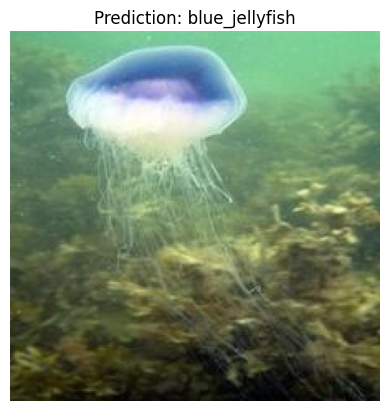

In [29]:
#이미지 하나로 실험#

from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/AIFFEL_DLTHON/Train_Test_Valid/test/blue_jellyfish/10.jpg'

image = Image.open(image_path).convert('RGB')
input_image = transform(image).unsqueeze(0).to(device)

model.load_state_dict(torch.load("/content/drive/MyDrive/AIFFEL_DLTHON/jellyfish-efficientnet-b0.pth"))
model.eval()

with torch.no_grad():
    output= model(input_image)
    pred = output.argmax(1).item()

class_name = train_dataset.classes[pred]
print(f"예측 결과: {class_name}")

plt.imshow(image)
plt.title(f"Prediction: {class_name}")
plt.axis('off')
plt.show()


In [31]:
#전체 test data 평가

from torchvision import datasets
from torch.utils.data import DataLoader

test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

model.load_state_dict(torch.load("/content/drive/MyDrive/AIFFEL_DLTHON/jellyfish-efficientnet-b0.pth"))
model.eval()

test_correct= 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = test_correct / len(test_loader.dataset)
print(f"Test 정확도: {test_acc*100:.2f}%")

Test 정확도: 92.50%


#EfficientNet 결과 히트맵으로 나타내기

In [32]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39680 sha256=25094edc43ebdcd259a0fef865812b41fdcfe2ff2b8b28ba9e40a1f80d1b26bc
  Stored in directory: /root/.cache/pip/wheels/8b/0d/d2/b12bec1ccc028921fb98158042ade2d19dae73925dfc636954
Successfully built grad-cam


In [33]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from efficientnet_pytorch import EfficientNet

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = torch.nn.Linear(model._fc.in_features, 6)
model.load_state_dict(torch.load('/content/drive/MyDrive/AIFFEL_DLTHON/jellyfish-efficientnet-b0.pth'))
model = model.to(device)
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [38]:
image_path = '/content/drive/MyDrive/AIFFEL_DLTHON/Train_Test_Valid/test/compass_jellyfish/04.jpg'
image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0).to(device)

rgb_img = transforms.ToTensor()(image).permute(1,2,0).numpy()

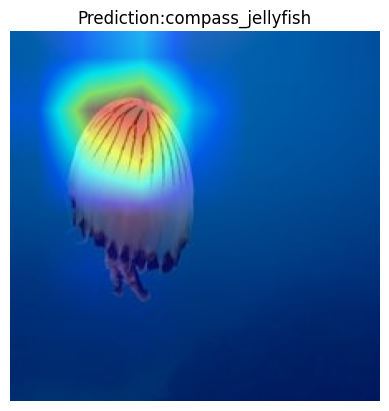

In [43]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM

target_layer = model._blocks[-1]._project_conv

cam = GradCAM(model=model, target_layers=[target_layer])


output = model(input_tensor)
pred_class = output.argmax(1).item()

targets= [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor= input_tensor, targets=targets) [0]

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title(f"Prediction:{train_dataset.classes[pred_class]}")
plt.axis('off')
plt.show()